<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [1]:
!pip install gdown -q


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gdown

url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
output = 'Data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO
From (redirected): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO&confirm=t&uuid=0f9444af-115a-4d0a-a53a-587b5109b165
To: C:\Users\Gulfik\Desktop\petprojects\hseContest\ml\hws\lesson_6_uplift\homework\Data.zip
100%|██████████| 289M/289M [00:22<00:00, 12.9MB/s] 


'Data.zip'

In [4]:
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_aggs = pd.read_csv('./content/AGGS_FINAL.csv')
df_campaigns = pd.read_csv('./content/CAMPAINGS.csv')
df_contracts = pd.read_csv('./content/CONTRACTS_FINAL.csv')
df_people = pd.read_csv('./content/PEOPLE_IN_CAMPAINGS_FINAL.csv')

In [3]:
dfs = [df_aggs,
       df_campaigns,
       df_contracts,
       df_people]

for df in dfs:
    df.drop(columns=['Unnamed: 0'], inplace=True)
    print(df.head(3))

         x1        x2        x3        x4        x5        x6        x7  \
0  0.654343 -1.439286 -0.011475  2.039457  0.843580 -0.977480 -0.768019   
1  2.583579  1.755569  3.360186 -1.122864  0.034201 -0.269607 -1.503646   
2  0.296030 -0.937075  1.073280  1.874636 -0.981216 -1.100187 -0.331181   

         x8        x9   report_dt  user_id  age city  
0 -1.044127  0.025673  2025-01-31  1066338   26  Ufa  
1  1.040289 -1.691606  2024-11-30    13900   35  Ufa  
2 -1.575637  0.474965  2025-03-31  4063636   28  Ufa  
  campaing_id  product_id channel
0       iddqd           1    push
1      idclip           1     sms
2        iddt           1  banner
   user_id contract_date  product_id              contract_id
0  4008279    2024-11-03           1  0001_2024-11-03_4008279
1  2079035    2024-11-08           1  0001_2024-11-08_2079035
2   103088    2024-11-13           1   0001_2024-11-13_103088
  campaing_id  user_id  t_flag delivery_date
0      idclip  1099975       1    2024-11-06
1    

In [4]:
df_people_campaigns = df_people.merge(df_campaigns, how='left', on='campaing_id')
df_people_campaigns.head()

,campaing_id,user_id,t_flag,delivery_date,product_id,channel
0,idclip,1099975,1,2024-11-06,1,sms
1,iddqd,1162,1,2024-11-08,1,push
2,iddqd,42991,1,2024-11-07,1,push
3,idclip,142343,0,unknown,1,sms
4,iddqd,24623,0,unknown,1,push


In [5]:
df_joined = df_people_campaigns.merge(df_contracts, how='left', on='user_id')
df_joined.head()

,campaing_id,user_id,t_flag,delivery_date,product_id_x,channel,contract_date,product_id_y,contract_id
0,idclip,1099975,1,2024-11-06,1,sms,2024-11-11,1.0,0001_2024-11-11_1099975
1,iddqd,1162,1,2024-11-08,1,push,2024-11-13,1.0,0001_2024-11-13_1162
2,iddqd,42991,1,2024-11-07,1,push,NaN,NaN,NaN
3,idclip,142343,0,unknown,1,sms,2024-11-17,1.0,0001_2024-11-17_142343
4,iddqd,24623,0,unknown,1,push,NaN,NaN,NaN


In [6]:
df_joined.product_id_x.nunique(), df_joined.product_id_y.nunique()

(1, 1)

Product id в таблицах уникальны, поэтому удалим этот признак

In [7]:
df_joined.drop(columns=['product_id_x', 'product_id_y'], inplace=True)

Переведём даты в datetime

In [8]:
df_aggs.report_dt = pd.to_datetime(df_aggs.report_dt)
df_joined.contract_date = pd.to_datetime(df_joined.contract_date)
df_joined.delivery_date = pd.to_datetime(df_joined.delivery_date, errors='coerce')

df_joined.contract_date.describe(), df_joined.delivery_date.describe()

(count                           337635
 mean     2024-11-13 18:56:33.906437632
 min                2024-11-01 00:00:00
 25%                2024-11-11 00:00:00
 50%                2024-11-13 00:00:00
 75%                2024-11-17 00:00:00
 max                2024-11-28 00:00:00
 Name: contract_date, dtype: object,
 count                           260000
 mean     2024-11-05 20:42:25.919999744
 min                2024-11-04 00:00:00
 25%                2024-11-05 00:00:00
 50%                2024-11-06 00:00:00
 75%                2024-11-07 00:00:00
 max                2024-11-08 00:00:00
 Name: delivery_date, dtype: object)

In [9]:
df_joined.channel.unique()

array(['sms', 'push', 'banner', 'other_ads'], dtype=object)

Заменим channel на no_comm, если у клиента t_flag = 0

In [10]:
df_joined.channel = df_joined.apply(lambda x: 'no_comm' if x.t_flag else x.channel, axis=1)
df_joined.channel.unique()

array(['no_comm', 'sms', 'push', 'banner', 'other_ads'], dtype=object)

In [11]:
def create_target(x):
    """
    Создание таргета на основе условий.

    Параметры:
    x (pd.Series): Строка DataFrame с необходимыми полями.

    Возвращает:
    int: 1, если условия выполнены, иначе 0.
    """
    contract_date = x["contract_date"]
    delivery_date = x["delivery_date"]
    t_flag = x["t_flag"]

    if pd.isna(contract_date):
        return 0

    # Условие для целевой группы (t_flag == 1) - покупка в течение 14 дней после доставки
    if t_flag == 1 and not pd.isna(delivery_date) and (0 <= (contract_date - delivery_date).days <= 14):
        return 1

    # Условие для контрольной группы (t_flag == 0) - покупка в течение 21 дня с начала кампании
    campaign_start = pd.Timestamp("2024-11-01")
    if t_flag == 0 and (0 <= (contract_date - campaign_start).days <= 21):
        return 1

    return 0

In [12]:
df_joined['target'] = df_joined.apply(create_target, axis=1)
df_joined.head()

,campaing_id,user_id,t_flag,delivery_date,channel,contract_date,contract_id,target
0,idclip,1099975,1,2024-11-06,no_comm,2024-11-11,0001_2024-11-11_1099975,1
1,iddqd,1162,1,2024-11-08,no_comm,2024-11-13,0001_2024-11-13_1162,1
2,iddqd,42991,1,2024-11-07,no_comm,NaT,NaN,0
3,idclip,142343,0,NaT,sms,2024-11-17,0001_2024-11-17_142343,1
4,iddqd,24623,0,NaT,push,NaT,NaN,0


In [13]:
df_joined.drop(['contract_date', 'contract_id'], axis=1, inplace=True)

Разобъем на целевую и контрльные группы

In [14]:
df_target = df_joined[~df_joined['delivery_date'].isna()]
df_control = df_joined[df_joined['delivery_date'].isna()].drop('delivery_date', axis=1)

df_target.shape, df_control.shape

((260000, 6), (260000, 5))

Найдем пересечение пользователей в группах

In [15]:
users_target = set(df_target['user_id'])
users_control = set(df_control['user_id'])

len(users_target.intersection(users_control))

60000

Найдем пересечение по кампаниям

In [16]:
for campaign in df_joined['campaing_id'].unique():
    df_campaign = df_joined[df_joined['campaing_id'] == campaign]
    users_target = set(df_campaign[df_campaign['t_flag'] == 1]['user_id'])
    users_control = set(df_campaign[df_campaign['t_flag'] == 0]['user_id'])
    overlapping_users = users_target.intersection(users_control)
    print(f'{campaign}: {len(overlapping_users)}')

idclip: 0
iddqd: 0
iddt: 0
idkfa: 0


In [17]:
campaign_users = df_joined.groupby('campaing_id')['user_id'].apply(set).to_dict()
campaign_ids = list(campaign_users.keys())

for i, campaign_a in enumerate(campaign_ids):
    for campaign_b in campaign_ids[i + 1:]:
        overlapping_users = campaign_users[campaign_a].intersection(campaign_users[campaign_b])
        if overlapping_users:
            print(f"{campaign_a} & {campaign_b}: {len(overlapping_users)}")

idclip & iddqd: 60000


Видим пересечения пользователей в idclip и iddqd. Это может повлиять на оценку uplift-модели, так как появляется искажение групп - например, пользователь мог находиться в контрольной группе одной кампании, но при этом получить коммуникацию из другой. Надо будет учесть эти пересечения при обучении модели, например, присвоить какую-тто одну кампанию, в зависимости от даты участия или добавить какой-то новый признак участия в мультикампаниию.

In [18]:
uplift_dict = df_joined.groupby('campaing_id').apply(
    lambda df: df[df['t_flag'] == 1]['target'].mean() - df[df['t_flag'] == 0]['target'].mean(),
    include_groups=False).to_dict()
uplift_dict

{'idclip': -0.48374999999999996,
 'iddqd': 0.39958750000000004,
 'iddt': 0.20198333333333335,
 'idkfa': 0.20198333333333335}

In [19]:
{df_campaigns.loc[df_campaigns['campaing_id'] == camp_id, 'channel'].values[0]: uplift
 for camp_id, uplift in uplift_dict.items() if camp_id in df_campaigns['campaing_id'].values}

{'sms': -0.48374999999999996,
 'push': 0.39958750000000004,
 'banner': 0.20198333333333335,
 'other_ads': 0.20198333333333335}

Анализ показал, что кампания, использующая SMS, продемонстрировала отрицательный uplift. Это означает, что клиенты, которые не получали SMS-рассылку, чаще совершали покупки по сравнению с теми, кто получил сообщение.

Наибольший положительный uplift был зафиксирован у push-уведомлений, тогда как баннерная реклама и другие рекламные каналы показали одинаковый, но положительный эффект.

При этом важно учитывать, что у SMS- и push-кампаний была перекрестная аудитория. Возможно, негативный uplift SMS-рассылки связан с тем, что значительная часть контрольной группы SMS впоследствии совершила покупку после получения push-уведомления.
В то же время, высокий uplift push-уведомлений может быть обусловлен тем, что клиенты, склонные игнорировать SMS-рекламу, оказались в контрольной группе push-кампании, что увеличило разницу в результатах.

<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [20]:
df_aggs_september = df_aggs[(df_aggs.report_dt.dt.year == 2024) & (df_aggs.report_dt.dt.month == 9)]
df_aggs_september.shape

(460000, 13)

In [21]:
df_joined = df_joined.merge(df_aggs_september,
                            how='inner',
                            on='user_id',
                            ).drop(['report_dt', 'delivery_date'], axis=1)
df_joined.head()

,campaing_id,user_id,t_flag,channel,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city
0,idclip,1099975,1,no_comm,1,0.822461,1.233201,-1.000185,2.585873,-0.584520,-0.268274,-0.727814,1.606372,1.814158,42,Moscow
1,iddqd,1162,1,no_comm,1,-1.224545,1.688111,0.150933,3.230149,-0.189105,0.551481,-1.229590,1.159411,-0.085720,39,Moscow
2,iddqd,42991,1,no_comm,0,-0.916137,1.368764,1.841319,-1.529691,-0.608003,-1.116932,1.178124,-0.884607,-1.726070,43,Moscow
3,idclip,142343,0,sms,1,-1.620401,2.449667,1.131850,1.021660,-1.212641,0.958422,1.039261,-0.964264,-2.225545,39,Smolensk
4,iddqd,24623,0,push,0,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,39,Ufa


In [22]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520000 entries, 0 to 519999
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   campaing_id  520000 non-null  object 
 1   user_id      520000 non-null  int64  
 2   t_flag       520000 non-null  int64  
 3   channel      520000 non-null  object 
 4   target       520000 non-null  int64  
 5   x1           520000 non-null  float64
 6   x2           520000 non-null  float64
 7   x3           520000 non-null  float64
 8   x4           520000 non-null  float64
 9   x5           520000 non-null  float64
 10  x6           520000 non-null  float64
 11  x7           520000 non-null  float64
 12  x8           520000 non-null  float64
 13  x9           520000 non-null  float64
 14  age          520000 non-null  int64  
 15  city         520000 non-null  object 
dtypes: float64(9), int64(4), object(3)
memory usage: 63.5+ MB


In [23]:
num_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age']

In [24]:
df_joined.groupby(['campaing_id', 't_flag'])[num_cols].mean().round(2)

x1    x2    x3    x4    x5   x6    x7    x8    x9    age
campaing_id t_flag                                                            
idclip      0       0.61  1.00  1.00 -0.61  0.61 -0.0 -0.00 -0.00  0.53  32.46
            1       0.61  1.00  1.00 -0.61  0.61 -0.0 -0.00 -0.00  0.53  32.54
iddqd       0       0.60  0.99  0.99 -0.61  0.59 -0.0 -0.00 -0.00  0.52  32.50
            1       0.60  1.00  1.00 -0.60  0.60 -0.0 -0.00 -0.00  0.52  32.45
iddt        0      -0.20 -1.01  0.20 -0.20  0.01 -0.0  0.34  0.33 -0.23  32.53
            1      -0.19 -1.00  0.20 -0.20 -0.00  0.0  0.34  0.33 -0.23  32.50
idkfa       0      -0.20 -1.01  0.20 -0.20  0.00 -0.0  0.34  0.33 -0.23  32.57
            1      -0.19 -1.00  0.20 -0.20 -0.00  0.0  0.34  0.33 -0.23  32.49

In [25]:
df_joined.groupby(['campaing_id', 't_flag'])[num_cols].median().round(2)

x1    x2    x3    x4    x5    x6    x7    x8    x9   age
campaing_id t_flag                                                            
idclip      0       0.70  1.00  1.00 -0.69  0.73 -0.00 -0.21 -0.56  0.58  32.0
            1       0.69  1.00  1.00 -0.69  0.72 -0.01 -0.19 -0.51  0.58  33.0
iddqd       0       0.69  0.99  0.99 -0.70  0.72  0.00 -0.21 -0.56  0.58  32.0
            1       0.68  1.00  0.99 -0.68  0.72 -0.00 -0.21 -0.56  0.57  32.0
iddt        0      -0.04 -1.00  0.15 -0.19  0.00  0.00  0.52  0.71 -0.25  33.0
            1      -0.03 -0.99  0.16 -0.18 -0.00  0.01  0.51  0.72 -0.25  33.0
idkfa       0      -0.04 -1.00  0.15 -0.19  0.00  0.00  0.52  0.71 -0.25  33.0
            1      -0.03 -0.99  0.16 -0.18 -0.00  0.01  0.51  0.72 -0.25  32.0

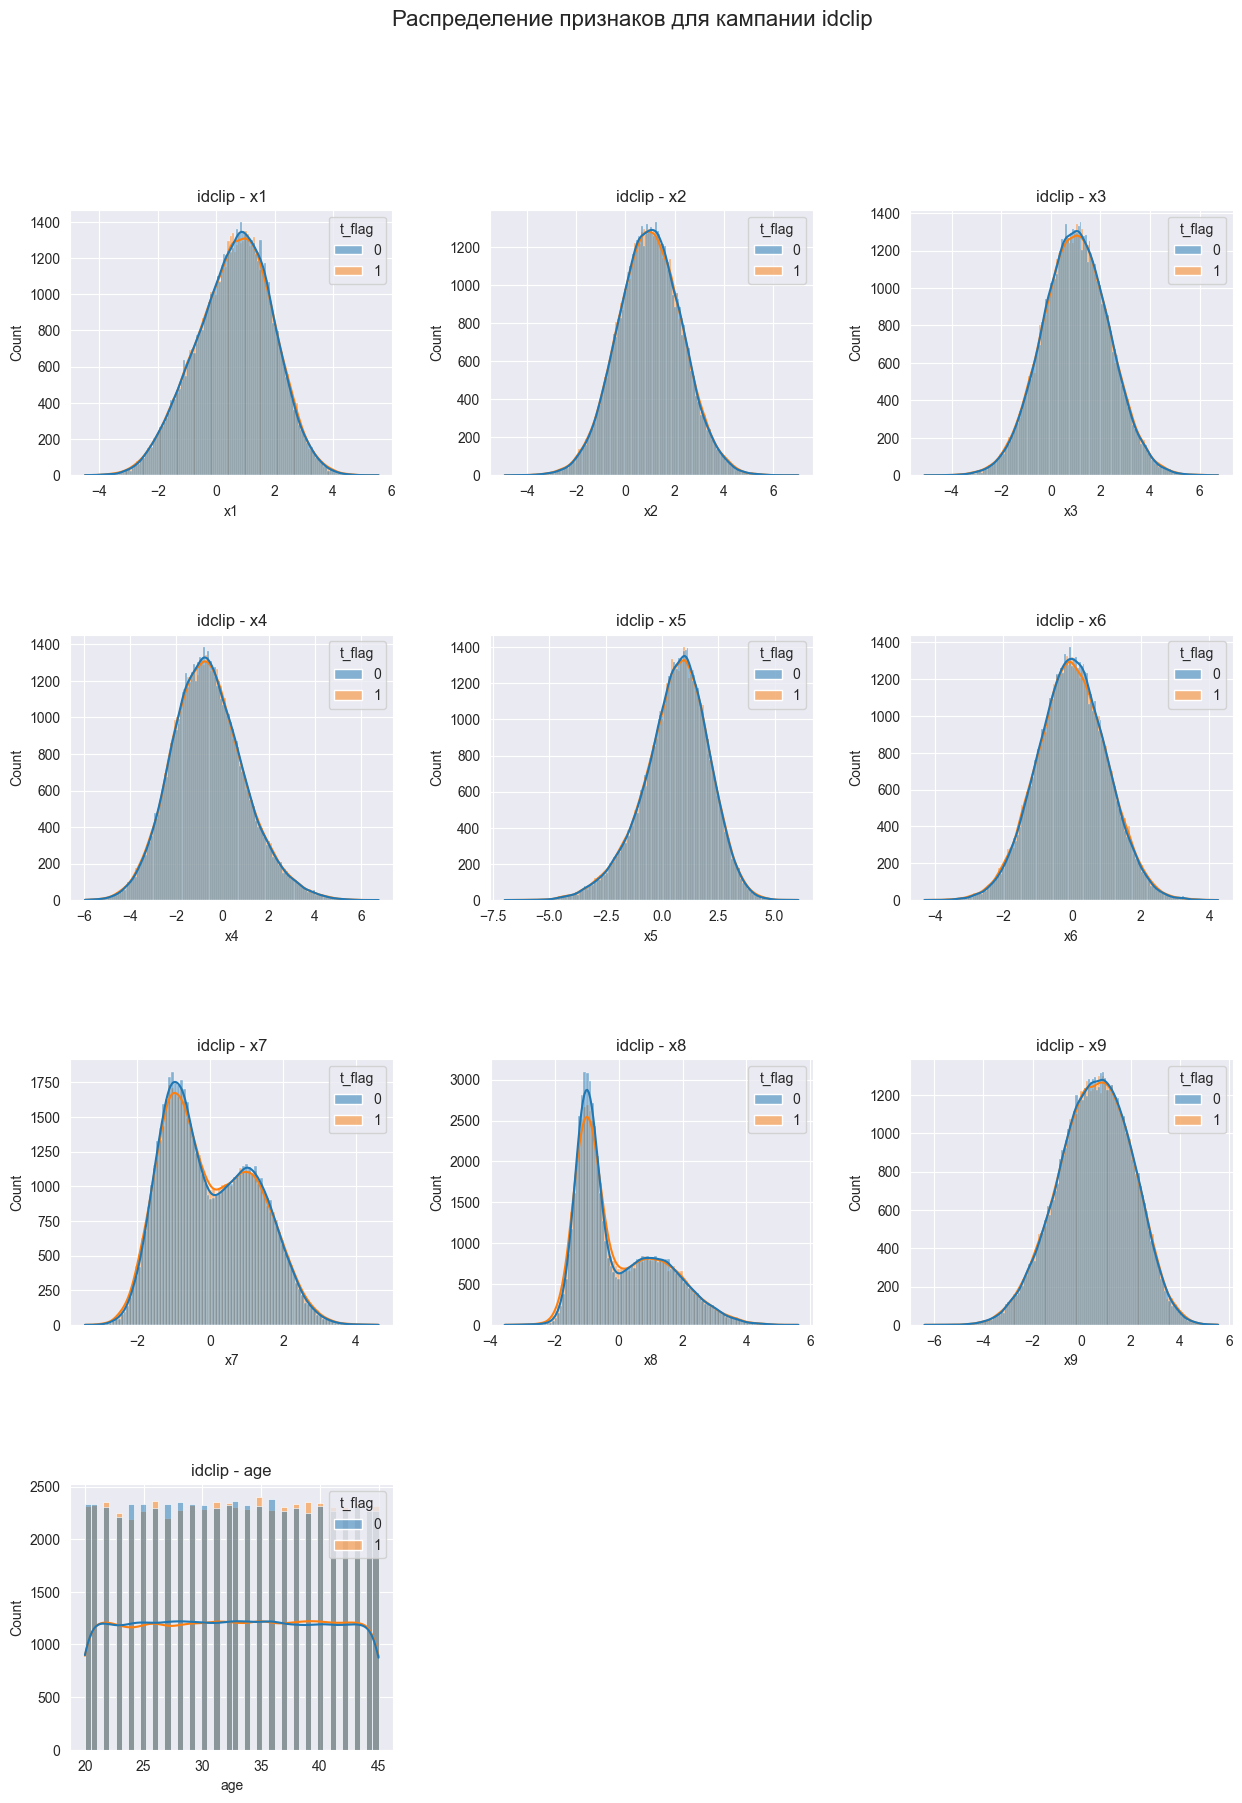

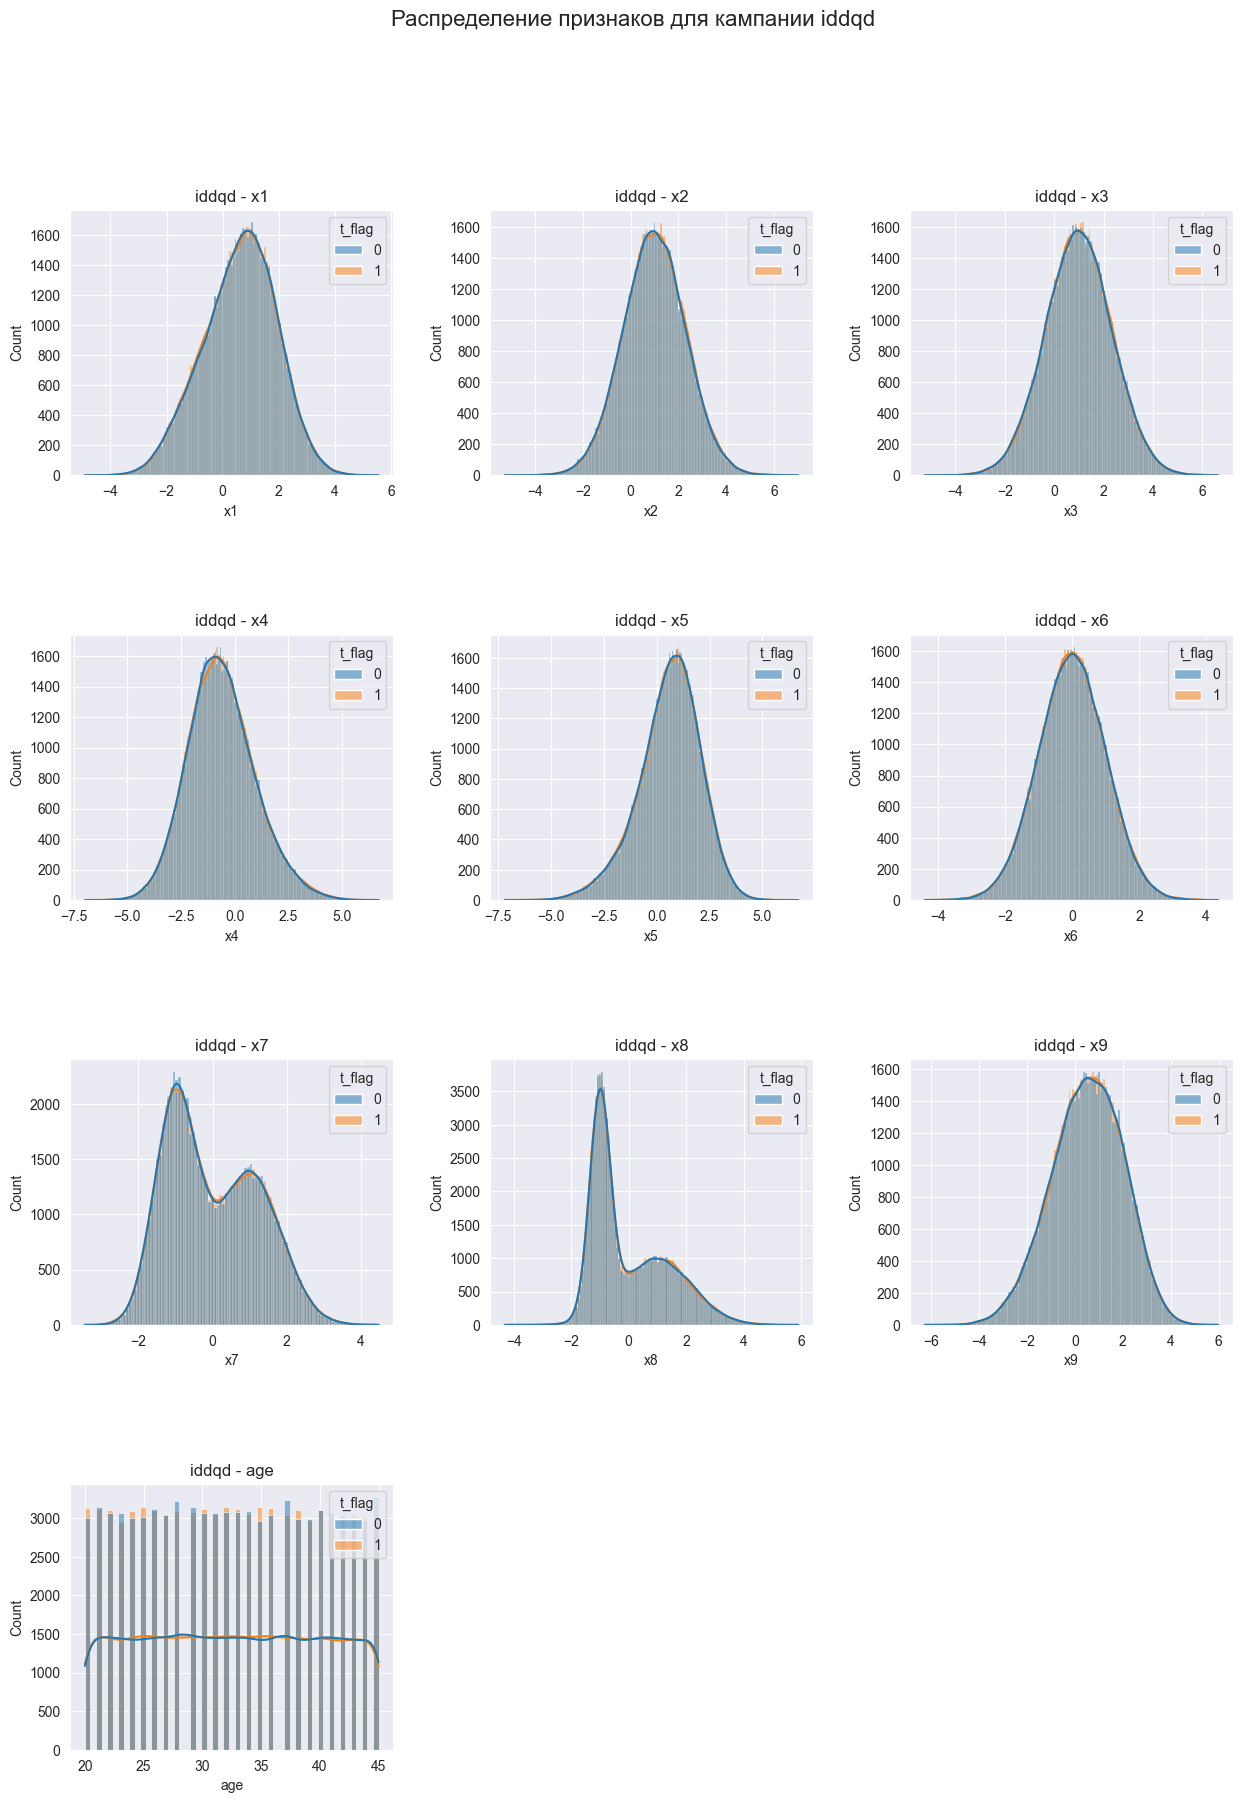

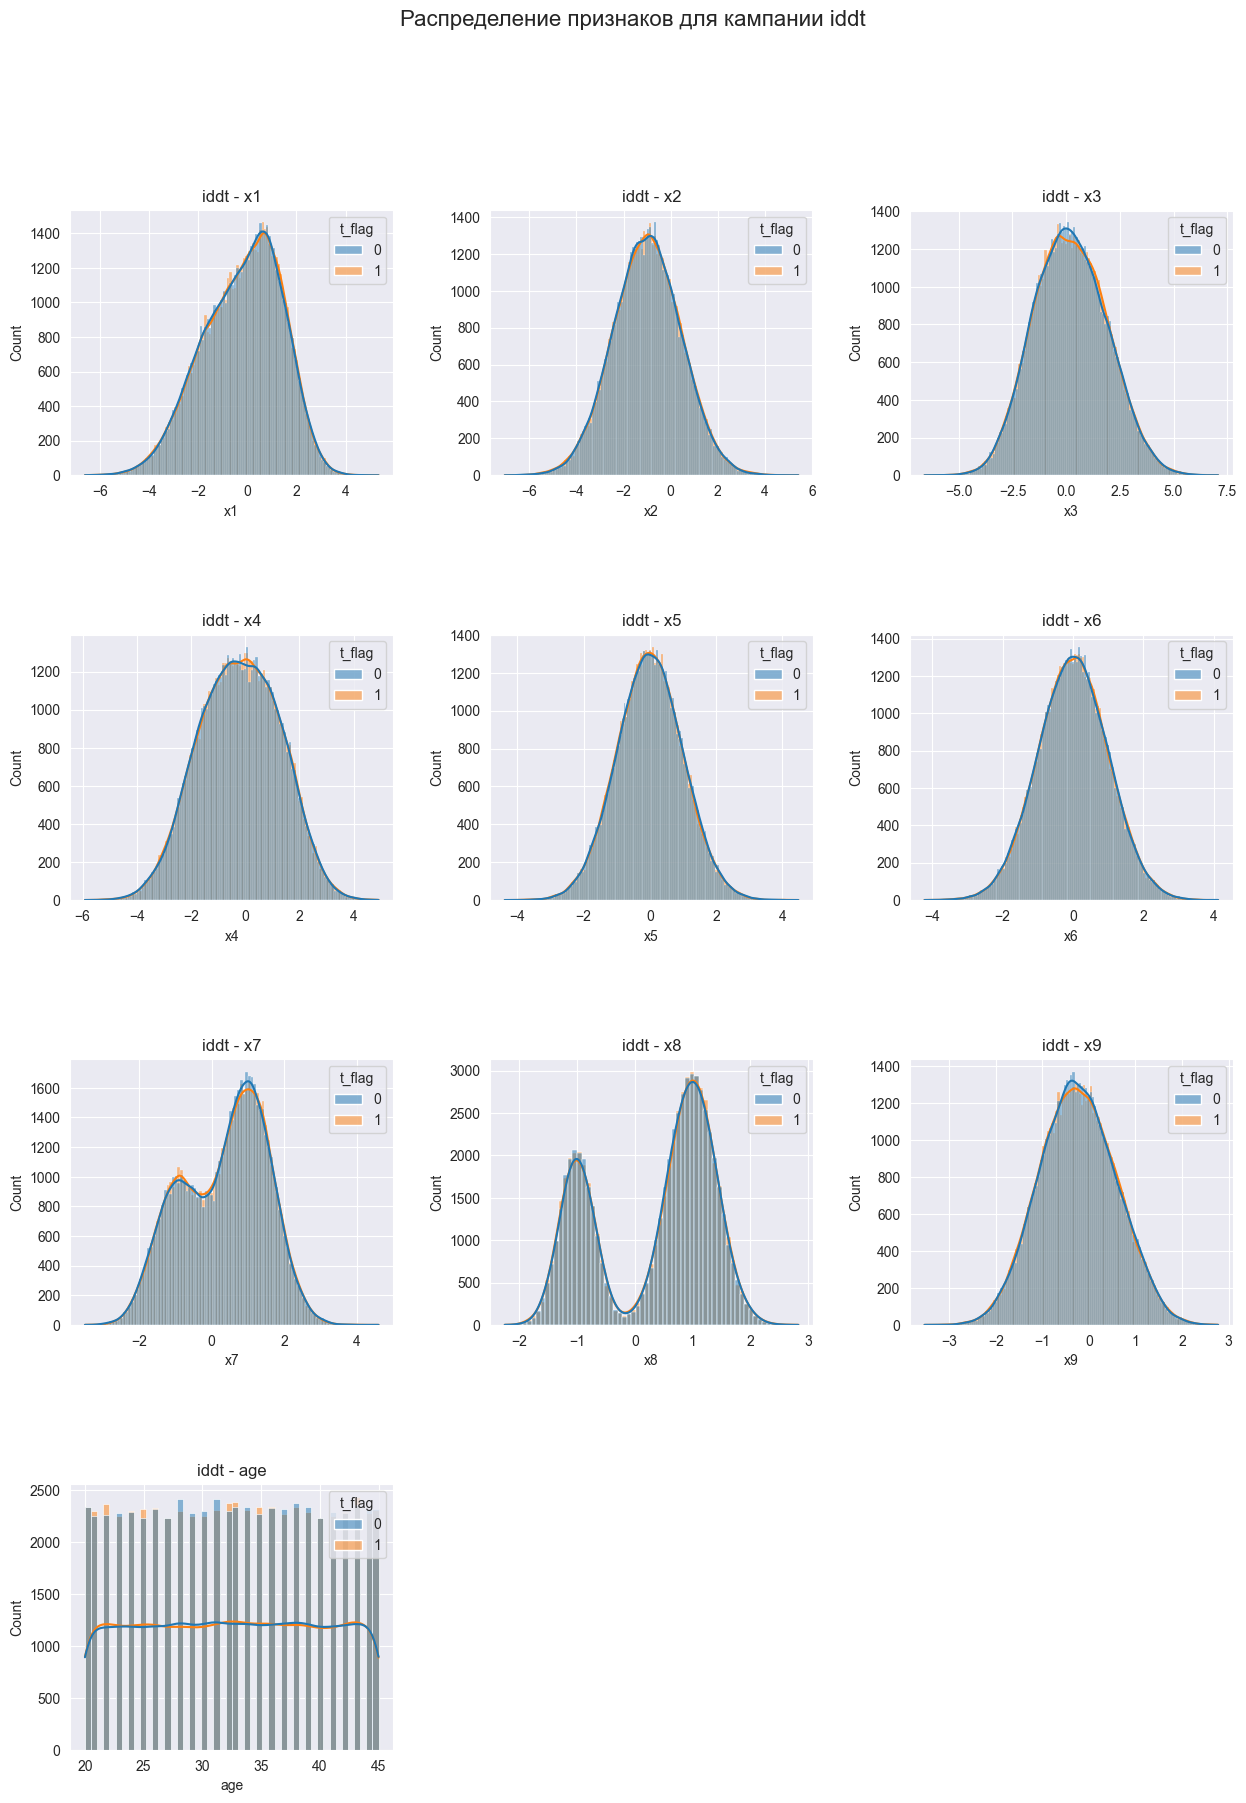

C:\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


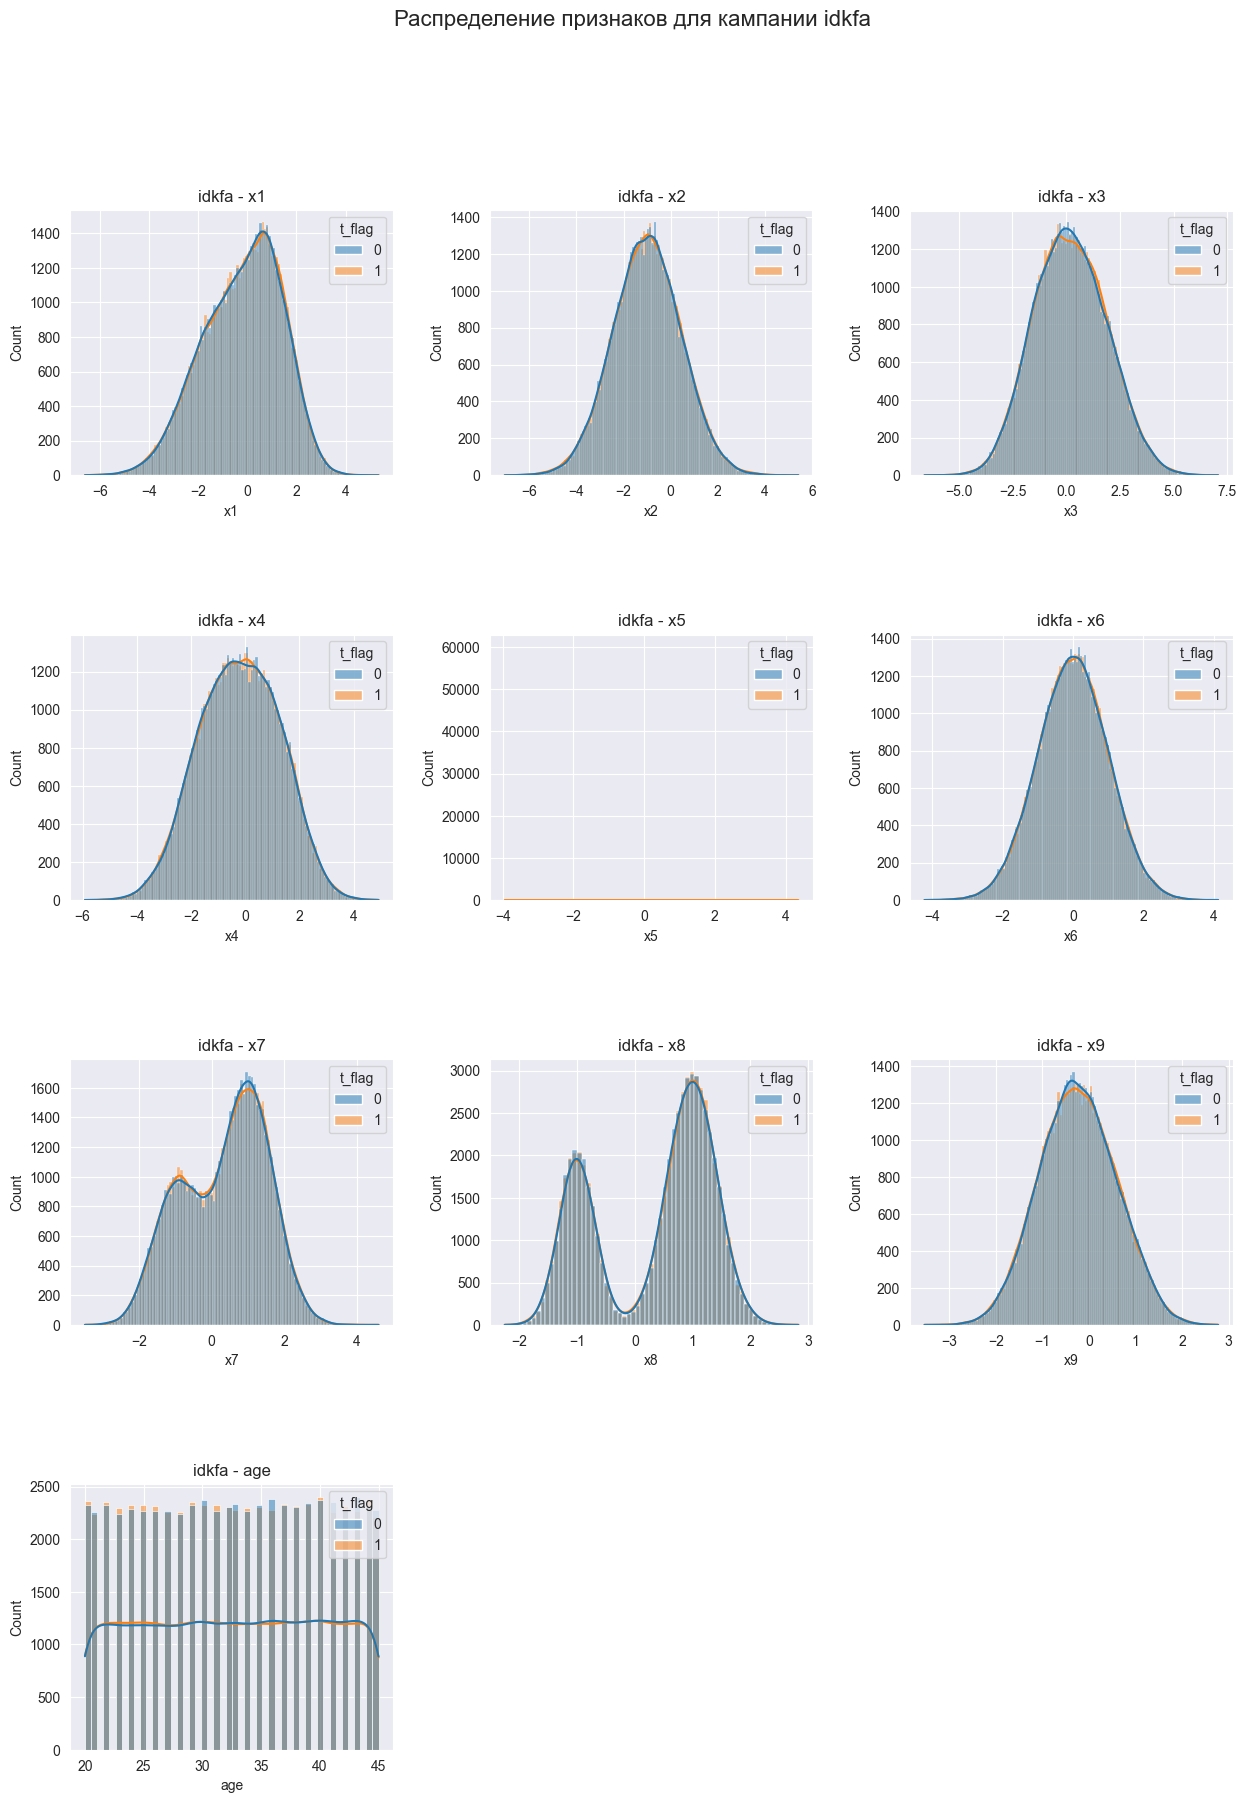

In [28]:
unique_campaigns = df_joined['campaing_id'].unique()
n_num_cols = len(num_cols)

for campaign in unique_campaigns:
    data = df_joined[df_joined['campaing_id'] == campaign]

    nrows = (n_num_cols // 3) + (1 if n_num_cols % 3 != 0 else 0)
    ncols = min(n_num_cols, 3)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    fig.subplots_adjust(wspace=0.3, hspace=0.6)
    ax = ax.flatten() if n_num_cols > 1 else [ax]

    for i, feature in enumerate(num_cols):
        sns.histplot(data=data, x=feature, hue='t_flag', ax=ax[i], kde=True)
        ax[i].set_title(f"{campaign} - {feature}")

    for j in range(i + 1, len(ax)):
        ax[j].axis("off")

    fig.suptitle(f"Распределение признаков для кампании {campaign}", fontsize=16)
    plt.show()

Разбиение на контрольную и целевую группу по каждой кампании однородно, кроме признака x5 для кампании idkfa

In [30]:
from psi.psi import calculate_psi

for campaign in df_joined['campaing_id'].unique():
    data = df_joined[df_joined['campaing_id'] == campaign]

    for feature in num_cols:
        psi_value = calculate_psi(
            expected=data[data['t_flag'] == 0][feature],
            actual=data[data['t_flag'] == 1][feature],
        )
        print(f"{campaign} - PSI для признака {feature}: {psi_value}")

idclip - PSI для признака x1: 0.00042744301765422916
idclip - PSI для признака x2: 0.0002603685392804008
idclip - PSI для признака x3: 0.0004546875722564355
idclip - PSI для признака x4: 0.00012903725083217483
idclip - PSI для признака x5: 0.0002387794198109868
idclip - PSI для признака x6: 0.001134609842715951
idclip - PSI для признака x7: 0.0019875256244458526
idclip - PSI для признака x8: 0.009678364255723259
idclip - PSI для признака x9: 0.00016822908768852023
idclip - PSI для признака age: 0.000261977328001752
iddqd - PSI для признака x1: 0.0002767697206009882
iddqd - PSI для признака x2: 0.00021561756105683059
iddqd - PSI для признака x3: 0.00019081748867860477
iddqd - PSI для признака x4: 0.000263721441935588
iddqd - PSI для признака x5: 0.00021383738927209807
iddqd - PSI для признака x6: 0.000213586268918342
iddqd - PSI для признака x7: 0.00016454908827573533
iddqd - PSI для признака x8: 0.0003232298576233026
iddqd - PSI для признака x9: 5.2528171787091363e-05
iddqd - PSI для п

C:\Users\Gulfik\Desktop\petprojects\hseContest\ml\hws\lesson_6_uplift\homework\psi\psi.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  input /= np.max(input) / (max - min)


Значимой популяционной разницы между контрольной и целевой группами не обнаружено (PSI меньше 0.1). Кроме признака х5, будем считать, что этот признак сломан, поэтому удалим его.

У нас есть категориальный признак city, посмотрим на его распределение

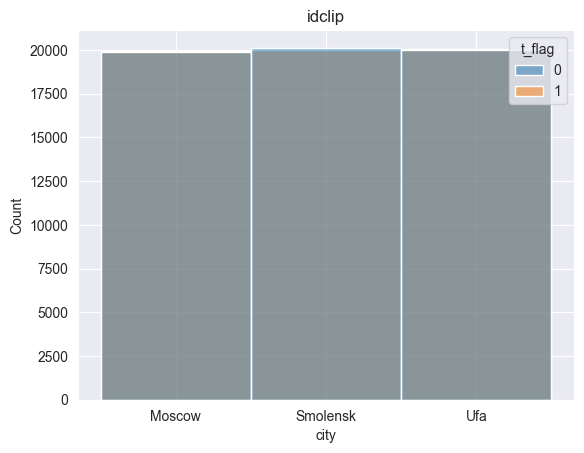

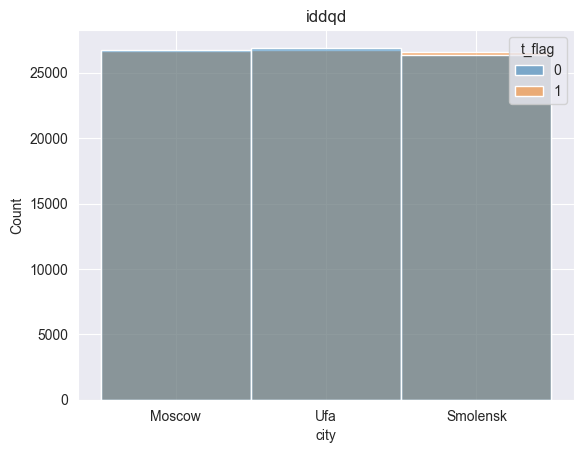

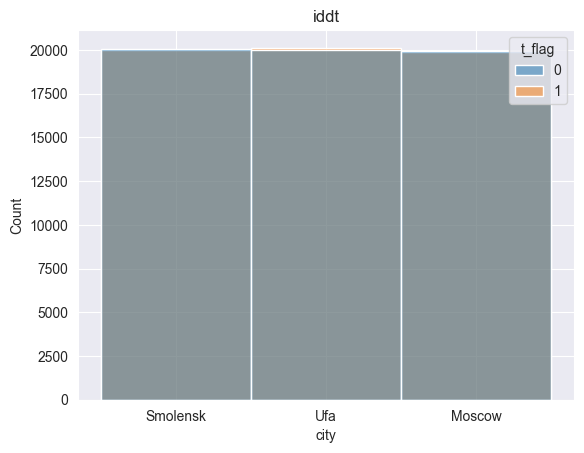

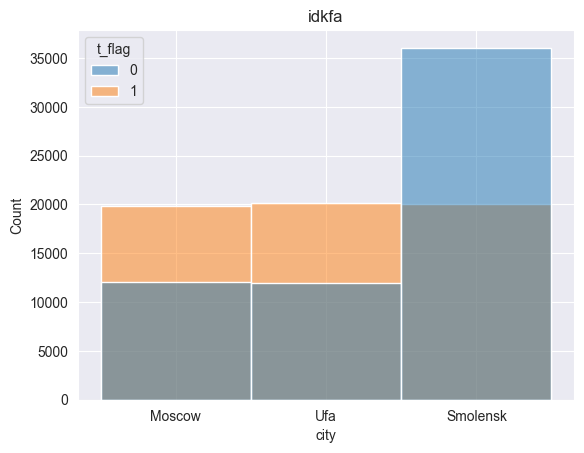

In [31]:
for campaign in df_joined.campaing_id.unique():
    data = df_joined[df_joined['campaing_id'] == campaign]
    fig, ax = plt.subplots()
    sns.histplot(data=data, x='city', hue='t_flag', ax=ax)
    ax.set_title(campaign)
    plt.show()

Для кампании idkfa city имеет разное распределение в группах. Эффект от компании может быть искажён.

Выполним анализ Uplift путем разбиения данных на квантильные интервалы и сравнения средних значений таргета в целевой и контрольной группе.

In [26]:
RANDOM_STATE = 42

In [27]:
num_cols = ['x1', 'x2', 'x3', 'x4', 'x6', 'x7', 'x8', 'x9', 'age']

Найдем признаки и те их значения, которые дают максимальный вклад в uplift по всей выборке

In [28]:
from sklearn.model_selection import train_test_split

train_index, test_index = train_test_split(df_joined.index, test_size=0.25, random_state=RANDOM_STATE)
df_train = df_joined.loc[train_index].copy()

for col in num_cols:
    col_bin = col + '_bin'
    df_train[col_bin] = pd.qcut(df_joined[col], q=6, duplicates='drop')
    tmp = df_train.groupby(by=[col_bin, 't_flag'], observed=False).agg({'target': 'mean'}).reset_index()
    tmp_1 = tmp[tmp['t_flag'] == 1].drop(columns='t_flag').set_index(col_bin)
    tmp_0 = tmp[tmp['t_flag'] == 0].drop(columns='t_flag').set_index(col_bin)
    print(tmp_1 - tmp_0)

                    target
x1_bin                    
(-6.602, -1.264]  0.156846
(-1.264, -0.307]  0.089367
(-0.307, 0.394]   0.092664
(0.394, 0.996]    0.097704
(0.996, 1.67]     0.094519
(1.67, 5.554]     0.089534
                                target
x2_bin                                
(-7.050000000000001, -1.613]  0.194040
(-1.613, -0.634]              0.147178
(-0.634, 0.143]               0.101349
(0.143, 0.878]                0.085595
(0.878, 1.737]                0.064579
(1.737, 7.023]                0.030303
                    target
x3_bin                    
(-6.597, -0.91]   0.060511
(-0.91, -0.0204]  0.098939
(-0.0204, 0.67]   0.105894
(0.67, 1.339]     0.110204
(1.339, 2.144]    0.114494
(2.144, 7.075]    0.133950
                    target
x4_bin                    
(-6.969, -1.933]  0.179330
(-1.933, -1.144]  0.186908
(-1.144, -0.471]  0.158117
(-0.471, 0.24]    0.118905
(0.24, 1.12]      0.045510
(1.12, 6.761]    -0.069995
                      target
x6_bin     

3. Построение моделей и оценка их качества (14 баллов)
Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [29]:
def split_data(df: pd.DataFrame, target_col: str = 'target', test_size: float = 0.25, random_state: int = RANDOM_STATE):
    train_index, test_index = train_test_split(df.index, test_size=test_size, random_state=random_state)

    X_train = df.loc[train_index].drop(columns=target_col)
    y_train = df.loc[train_index, target_col]
    X_val = df.loc[test_index].drop(columns=target_col)
    y_val = df.loc[test_index, target_col]

    return X_train, X_val, y_train, y_val

In [30]:
df_joined.drop(['channel', 'x5'], axis=1, inplace=True)

Попрбуем добавить новый признак, обозначающий пользовтеля с мультикампанией

In [31]:
df_joined_multicampaign = df_joined.copy()
df_joined_multicampaign['multi_campaign'] = df_joined['user_id'].duplicated(keep=False).astype(int)
df_joined_multicampaign[df_joined_multicampaign['multi_campaign'] == 1]

,campaing_id,user_id,t_flag,target,x1,x2,x3,x4,x6,x7,x8,x9,age,city,multi_campaign
1,iddqd,1162,1,1,-1.224545,1.688111,0.150933,3.230149,0.551481,-1.229590,1.159411,-0.085720,39,Moscow,1
2,iddqd,42991,1,0,-0.916137,1.368764,1.841319,-1.529691,-1.116932,1.178124,-0.884607,-1.726070,43,Moscow,1
3,idclip,142343,0,1,-1.620401,2.449667,1.131850,1.021660,0.958422,1.039261,-0.964264,-2.225545,39,Smolensk,1
11,idclip,53272,0,1,0.656322,0.684871,2.421487,-1.999850,0.812501,-1.393898,2.111360,1.672148,20,Moscow,1
13,idclip,28098,0,0,-0.394625,3.084795,0.147004,-2.155517,-0.738006,1.415686,-0.756639,-1.462933,22,Ufa,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519980,iddqd,16383,1,1,-1.190302,1.911323,2.612450,-2.756659,0.420644,2.016494,-0.735783,-2.627441,32,Moscow,1
519986,idclip,92223,0,1,2.964649,0.496761,0.608176,-2.046972,-0.320495,-0.529672,-0.258694,2.985199,32,Moscow,1
519993,idclip,81278,0,0,-0.321923,1.553811,0.937398,0.681921,-2.065844,1.489957,-0.849143,-1.458849,31,Moscow,1
519996,iddqd,131927,1,0,2.521111,-1.893176,2.540412,-1.912528,-0.653322,0.541760,-1.209625,1.752634,42,Ufa,1


In [32]:
df_joined.drop(['user_id'], axis=1, inplace=True)
df_joined_multicampaign.drop(['user_id'], axis=1, inplace=True)

In [33]:
campaigns = df_joined['campaing_id'].unique()

In [34]:
X_train, X_val, y_train, y_val = split_data(df_joined)

In [35]:
X_train_multicampaign, X_val_multicampaign, y_train_multicampaign, y_val_multicampaign = split_data(
    df_joined_multicampaign)

In [36]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklift.viz import plot_qini_curve
from sklearn.pipeline import Pipeline
from sklift.metrics import qini_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [58]:
def train_uplift_by_campaign(df: pd.DataFrame, model_function, custom_model=False, casual_model=False, show_plots=True):
    """
    Обучает отдельные модели для каждой кампании и сохраняет результаты uplift.

    Параметры:
        df_joined (pd.DataFrame): Датасет с кампаниями.
        model_function (Callable): Функция модели для обучения и предсказания uplift.
    """
    campaign_dict = {
        'idclip': 'sms',
        'iddqd': 'push',
        'iddt': 'banner',
        'idkfa': 'other_ads',
    }
    qini_auc_dict = {}

    for campaign in campaigns:
        print(f"Uplift для кампании: {campaign_dict[campaign]}")
        df_campaign = df[df["campaing_id"] == campaign].copy()
        X_train, X_val, y_train, y_val = split_data(df_campaign.drop(columns=['campaing_id']))

        if custom_model:
            qini_auc = model_function(pd.get_dummies(X_train, columns=['city']), y_train,
                                      pd.get_dummies(X_val, columns=['city']), y_val)
        elif casual_model:
            X_train['t_flag'] = X_train['t_flag'].astype('str')
            X_val['t_flag'] = X_val['t_flag'].astype('str')

            X_train = pd.get_dummies(X_train, columns=['city'])
            X_val = pd.get_dummies(X_val, columns=['city'])

            model = model_function()
            model.fit(X=X_train.drop(columns='t_flag').values,
                      y=y_train.values,
                      treatment=X_train['t_flag'].values)
            uplift_preds = model.predict(X=X_val.drop(columns='t_flag').values)

            if show_plots:
                plot_qini_curve(y_true=y_val,
                                uplift=pd.Series(uplift_preds.reshape(-1), index=X_val.index),
                                treatment=X_val['t_flag'].astype(int))
                plt.show()
            qini_auc = qini_auc_score(y_true=y_val,
                                      uplift=uplift_preds.reshape(-1),
                                      treatment=X_val['t_flag'].astype('int'))
        else:
            model = model_function()

            ct = ColumnTransformer([
                ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), ['city']),
                ('scaler', StandardScaler(), num_cols)
            ], remainder='passthrough')

            pipe = Pipeline([
                ('preprocessing', ct),
                ('model_uplift', model)
            ])

            pipe.fit(X_train.drop(columns='t_flag', axis=1), y_train, model_uplift__treatment=X_train['t_flag'])
            uplift_preds = pipe.predict(X_val.drop(columns='t_flag', axis=1))

            if show_plots:
                plot_qini_curve(y_val, uplift_preds, X_val['t_flag'])
                plt.show()
            qini_auc = qini_auc_score(y_val, uplift_preds, X_val['t_flag'])

        qini_auc_dict[campaign_dict[campaign]] = qini_auc

    return qini_auc_dict

In [38]:
def train_solo_model(X_train, y_train, X_test, y_test):
    """
    Solo Model (Logistic Regression)
    """
    model = LogisticRegression(random_state=RANDOM_STATE)
    model.fit(X_train, y_train)

    X_test_0 = X_test.copy()
    X_test_0['t_flag'] = 0
    y_pred_0 = model.predict_proba(X_test_0)[:, 1]

    X_test_1 = X_test.copy()
    X_test_1['t_flag'] = 1
    y_pred_1 = model.predict_proba(X_test_1)[:, 1]

    uplift = y_pred_1 - y_pred_0
    uplift_pd = pd.DataFrame(data=uplift, index=X_test.index, columns=['uplift'])
    uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
    qini_auc = qini_auc_score(y_true=y_test, uplift=uplift_pd['uplift'], treatment=X_test['t_flag'])

    sns.histplot(data=uplift_pd, x='uplift').set_title('Uplift Distribution')
    plt.show()

    return qini_auc

Uplift для кампании: sms


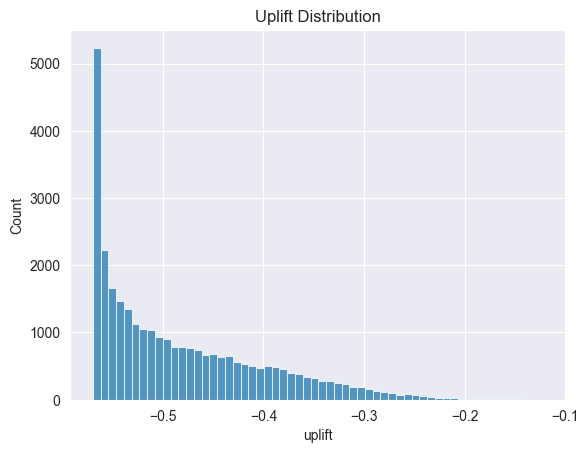

Uplift для кампании: push


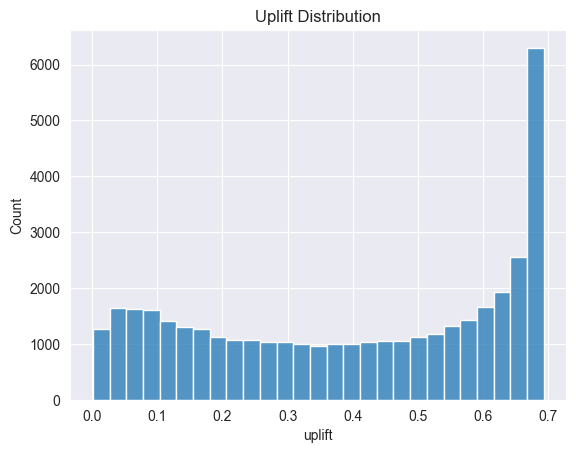

Uplift для кампании: banner


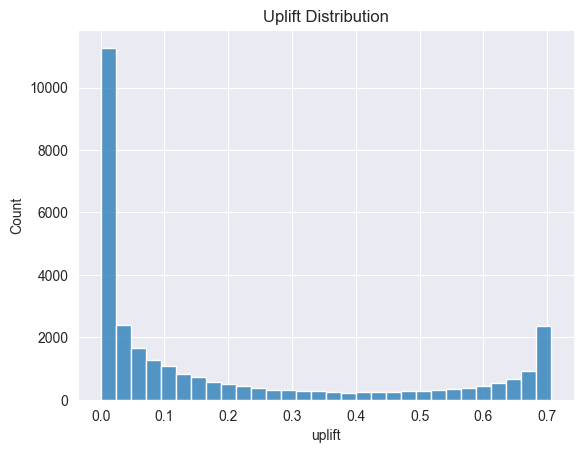

Uplift для кампании: other_ads


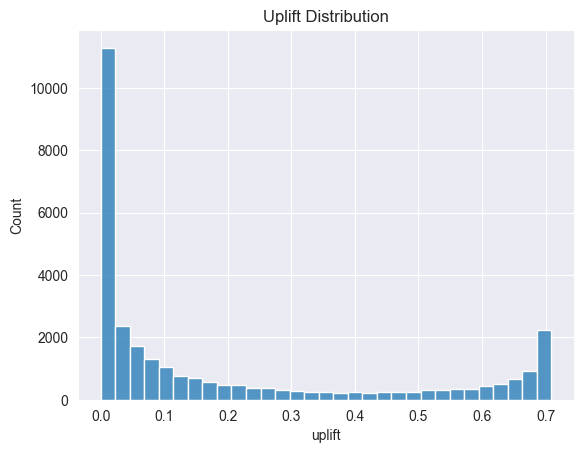

{'sms': -0.004214286294998315,
 'push': 0.010131305890421436,
 'banner': 0.0038347453104265908,
 'other_ads': -0.00022016835694179572}

In [42]:
custom_solo_model_score = train_uplift_by_campaign(df_joined, train_solo_model, custom_model=True)
custom_solo_model_score

Uplift для кампании: sms


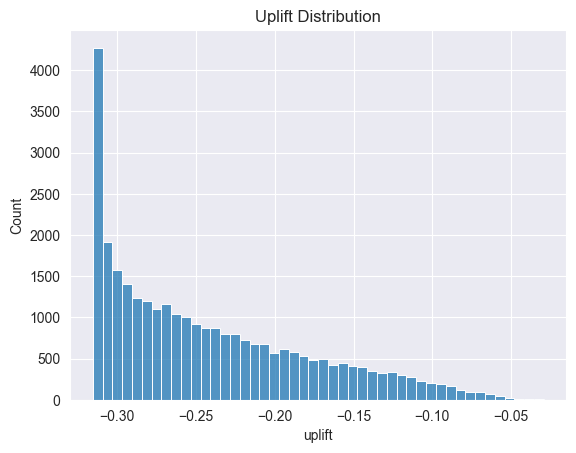

Uplift для кампании: push


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


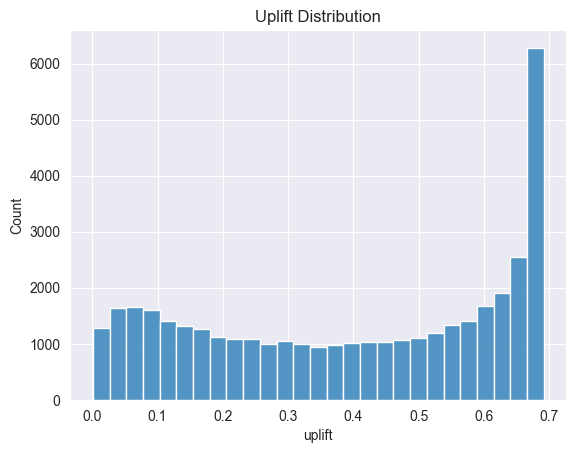

Uplift для кампании: banner


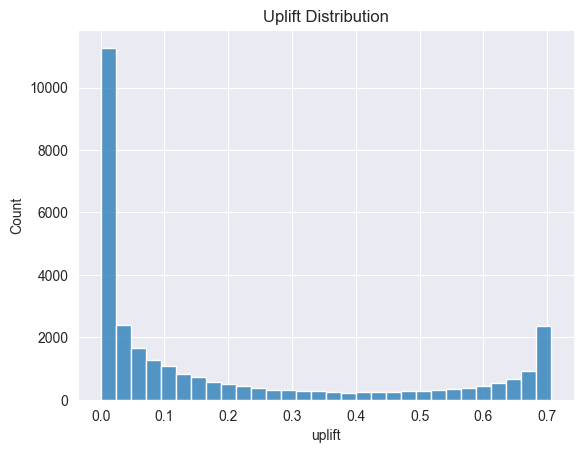

Uplift для кампании: other_ads


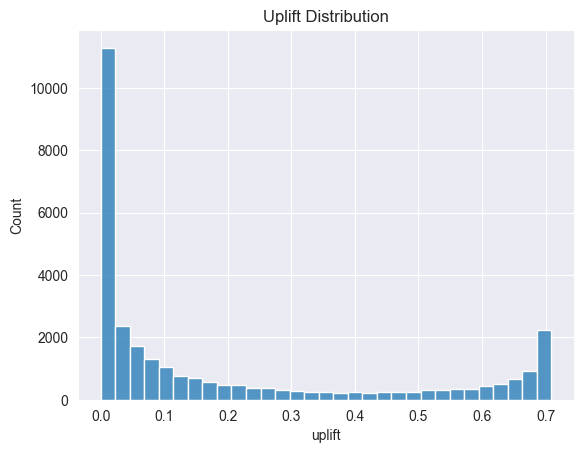

{'sms': -0.004214286294998315,
 'push': 0.010131305890421436,
 'banner': 0.0038347453104265908,
 'other_ads': -0.00022016835694179572}

In [43]:
custom_solo_multicampaign_model_score = train_uplift_by_campaign(df_joined_multicampaign, train_solo_model,
                                                                 custom_model=True)
custom_solo_multicampaign_model_score

На первых графиках uplift на датасете без дополнительного признака имеет нормальное распределение для sms и push коммуникаций. На датасете с дополнительным признаком графики кажутся чуть более адекватнее. Видно, что sms отрицательно влияет на вероятность покупки пользователем продукта.

На qini_auc_score наличие дополнительного признака никак не отразилось, поэтому в дальнейшем будем использовать обычный датасет.

Лучшее качество показала push кампании, sms - худшее (-0.004)

Посмотрим на результат более сложных моделей

In [44]:
from sklift.models import TwoModels


def two_model():
    """
    Возвращает Two-Model (CatBoost)
    """
    return TwoModels(
        estimator_trmnt=CatBoostClassifier(silent=True, eval_metric='Logloss', thread_count=-1,
                                           random_state=RANDOM_STATE),
        estimator_ctrl=CatBoostClassifier(silent=True, eval_metric='Logloss', thread_count=-1,
                                          random_state=RANDOM_STATE + 1)
    )

Uplift для кампании: sms


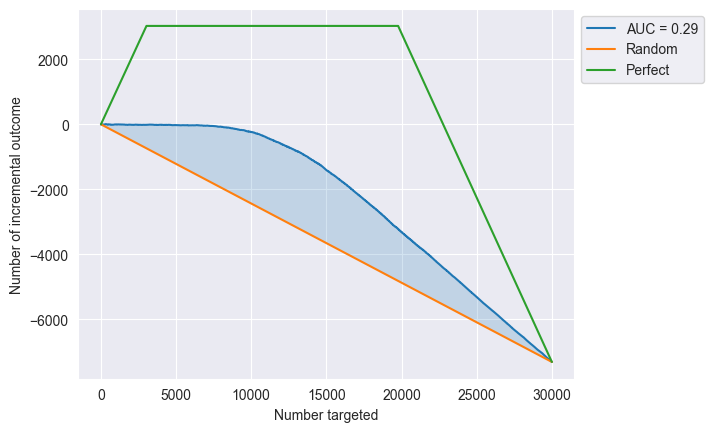

Uplift для кампании: push


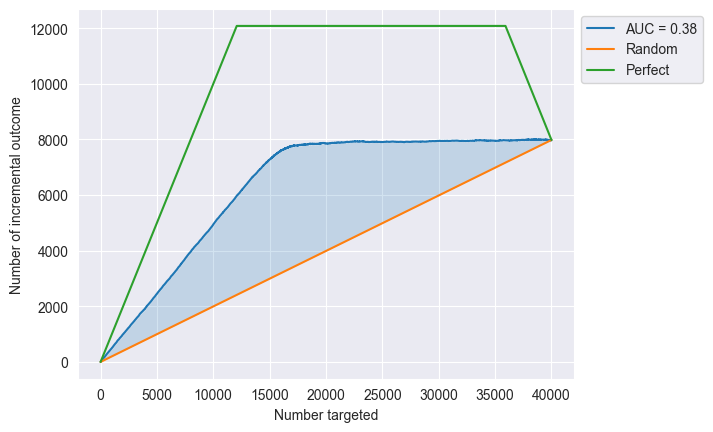

Uplift для кампании: banner


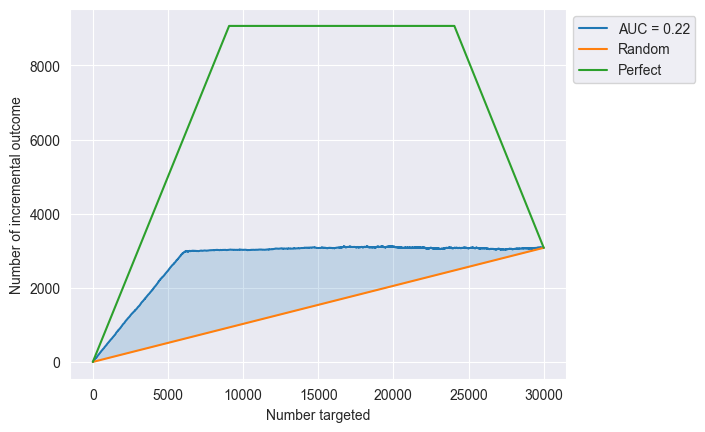

Uplift для кампании: other_ads


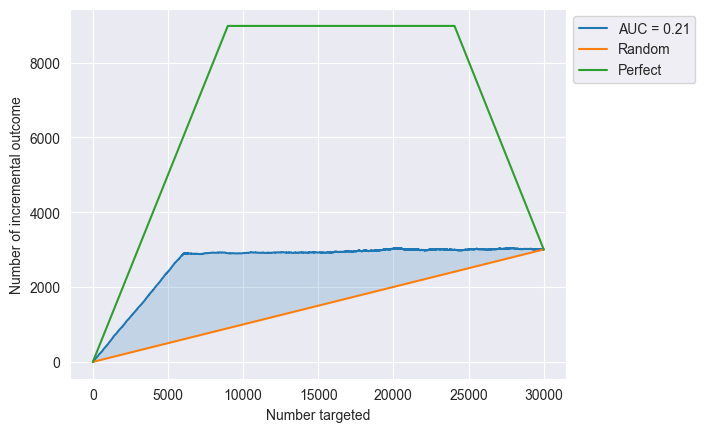

{'sms': 0.28506049647648385,
 'push': 0.3847155024654912,
 'banner': 0.21660483585054996,
 'other_ads': 0.2087497342158406}

In [45]:
simple_two_model_score = train_uplift_by_campaign(df_joined, two_model)
simple_two_model_score

Попробуем TwoModel с калибровкой

In [47]:



def two_model_calibrated():
    """
    Two-Model (CatBoost) с калибровкой
    """
    skf = StratifiedKFold(n_splits=5,
                          random_state=RANDOM_STATE,
                          shuffle=True)
    model_1 = CatBoostClassifier(silent=True, eval_metric='Logloss', thread_count=-1,
                                 random_state=RANDOM_STATE)
    model_2 = CatBoostClassifier(silent=True, eval_metric='Logloss', thread_count=-1,
                                 random_state=RANDOM_STATE + 1)

    calib_model_1 = CalibratedClassifierCV(estimator=model_1, method='isotonic', cv=skf)
    calib_model_2 = CalibratedClassifierCV(estimator=model_2, method='isotonic', cv=skf)

    return TwoModels(estimator_trmnt=calib_model_1,
                     estimator_ctrl=calib_model_2)

Uplift для кампании: sms


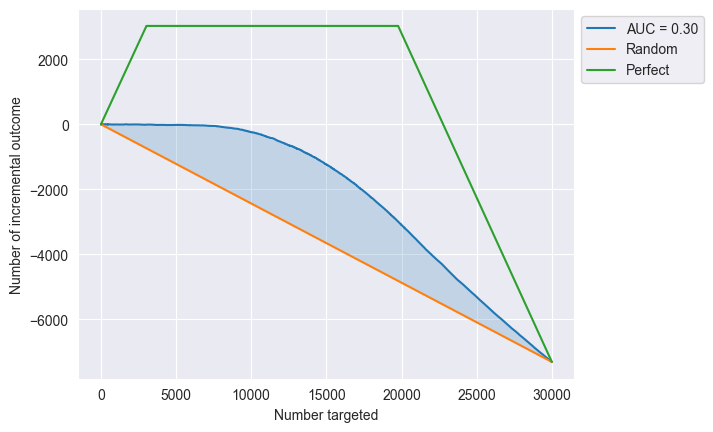

Uplift для кампании: push


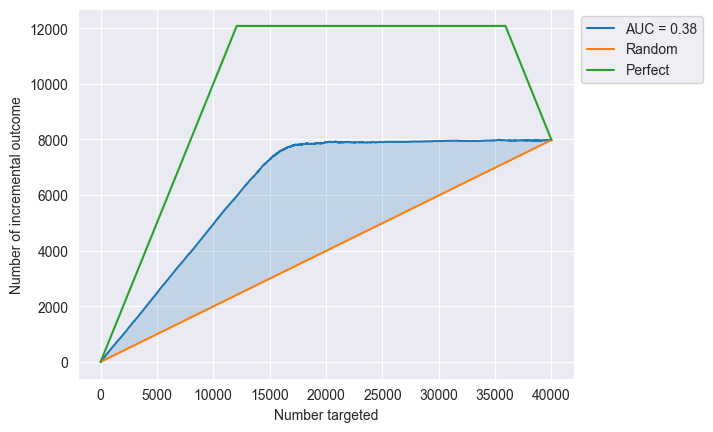

Uplift для кампании: banner


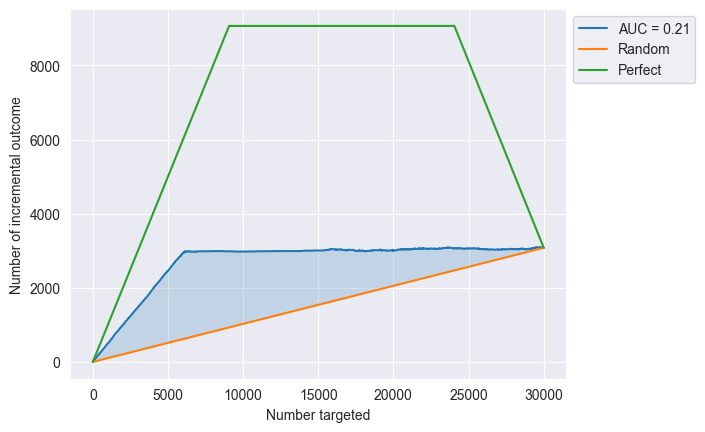

Uplift для кампании: other_ads


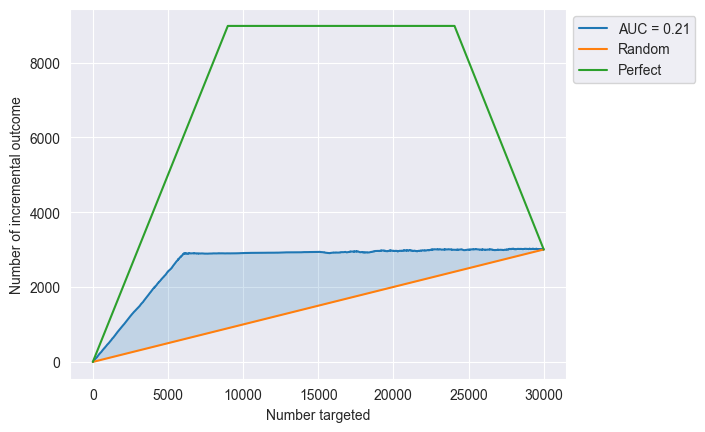

{'sms': 0.29788419924229137,
 'push': 0.38478754512389907,
 'banner': 0.21068464975821224,
 'other_ads': 0.20763792599488465}

In [48]:
two_model_calibrated_score = train_uplift_by_campaign(df_joined, two_model_calibrated)
two_model_calibrated_score

In [49]:
def class_transformation():
    """
    Class transformation
    """
    model = CatBoostClassifier(silent=True, eval_metric='Logloss', thread_count=-1,
                               random_state=RANDOM_STATE)
    return ClassTransformation(model)

Uplift для кампании: sms


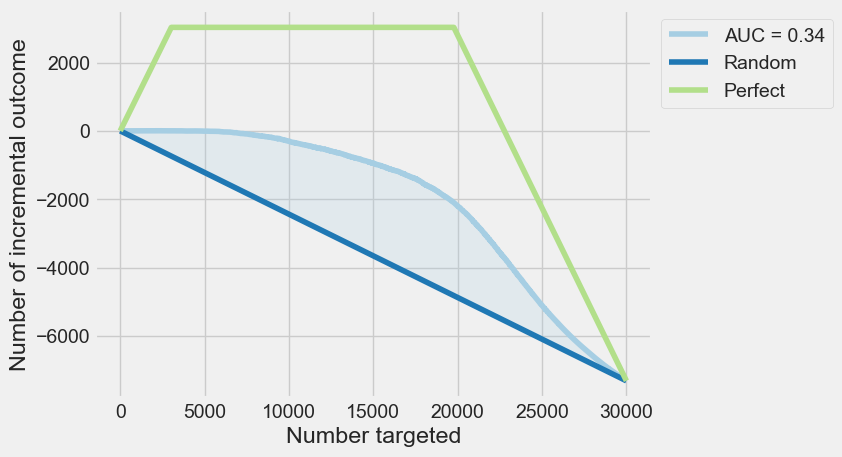

Uplift для кампании: push


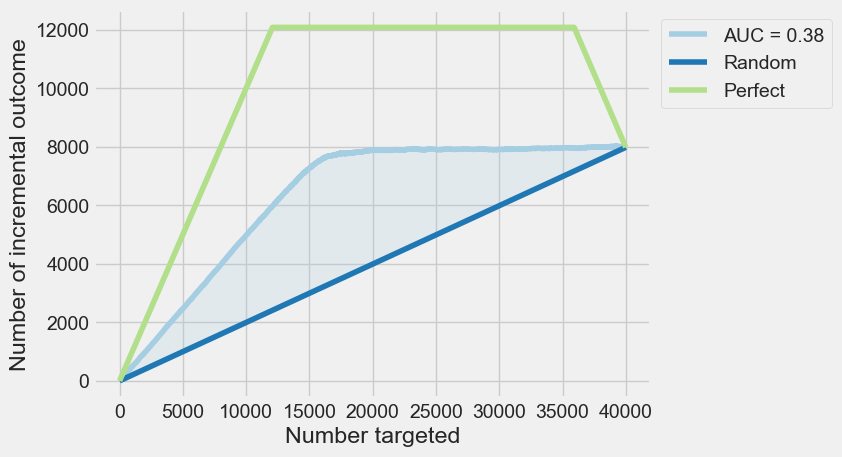

Uplift для кампании: banner


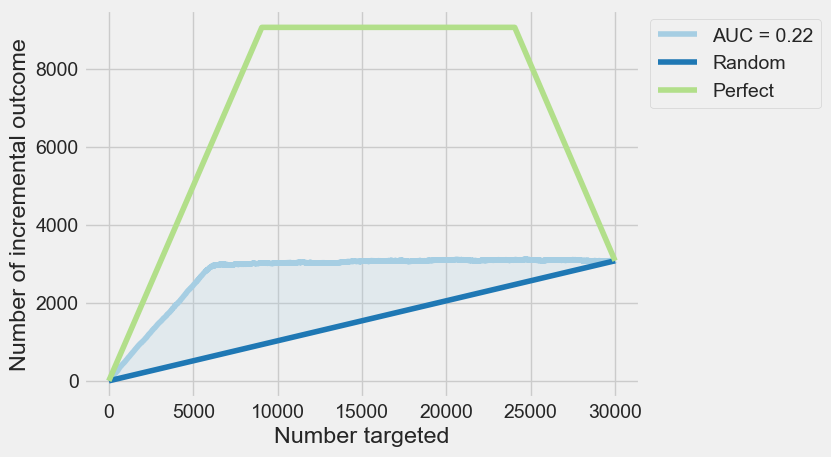

Uplift для кампании: other_ads


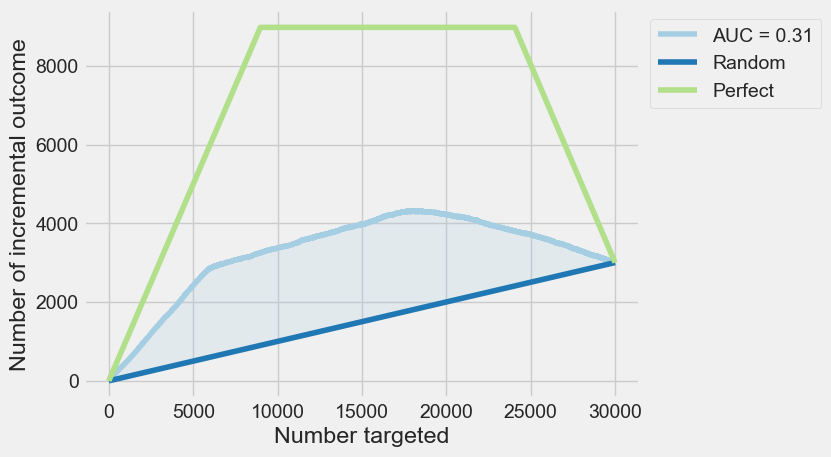

{'sms': 0.344327595425407,
 'push': 0.3843375772567313,
 'banner': 0.21686555096094043,
 'other_ads': 0.31472337678950735}

In [54]:
class_transformation_score = train_uplift_by_campaign(df_joined, class_transformation)
class_transformation_score

Uplift для кампании: sms


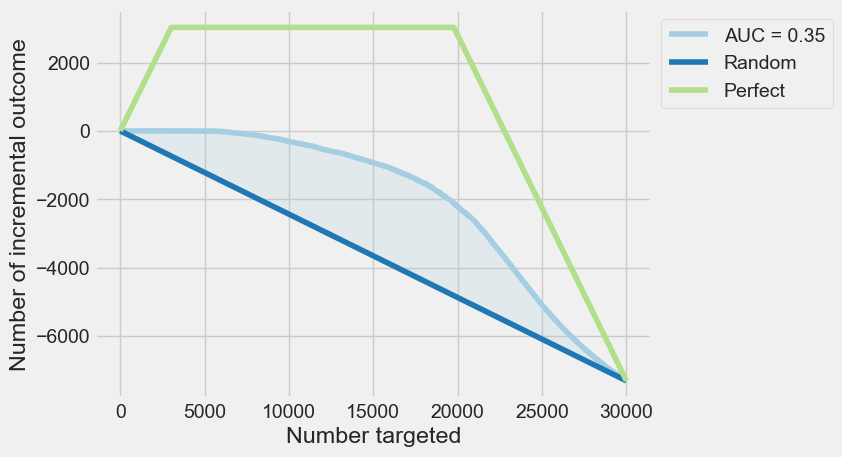

Uplift для кампании: push


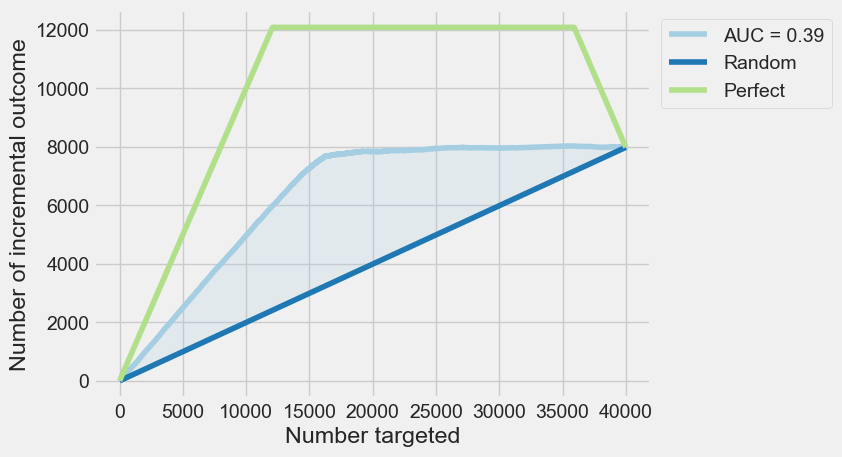

Uplift для кампании: banner


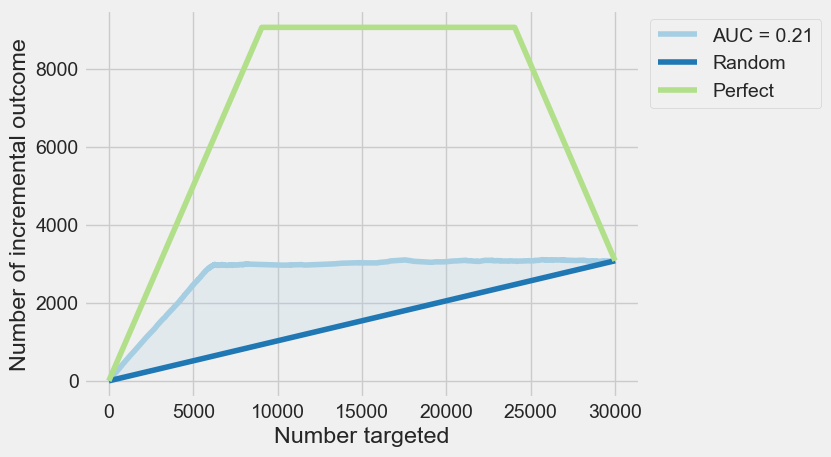

Uplift для кампании: other_ads


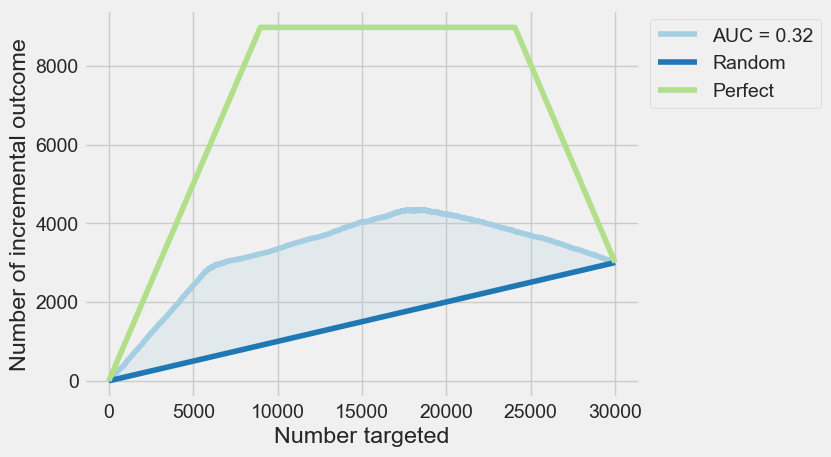

{'sms': 0.3456410620962357,
 'push': 0.38693684638648834,
 'banner': 0.2136444350135276,
 'other_ads': 0.3153091687542279}

In [60]:
def calibrated_class_transformation():
    """
    Class transformation с калибровкой и StratifiedKFold.
    """
    model = CatBoostClassifier(silent=True, eval_metric='Logloss', thread_count=-1, random_state=RANDOM_STATE)

    skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

    calib_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv=skf)

    return ClassTransformation(calib_model)


calibrated_class_transformation_score = train_uplift_by_campaign(df_joined, calibrated_class_transformation)
calibrated_class_transformation_score

In [51]:
from causalml.inference.tree import UpliftRandomForestClassifier


def uplift_rf():
    """
    Random forest
    """
    return UpliftRandomForestClassifier(control_name='0',
                                        random_state=RANDOM_STATE)

Uplift для кампании: sms


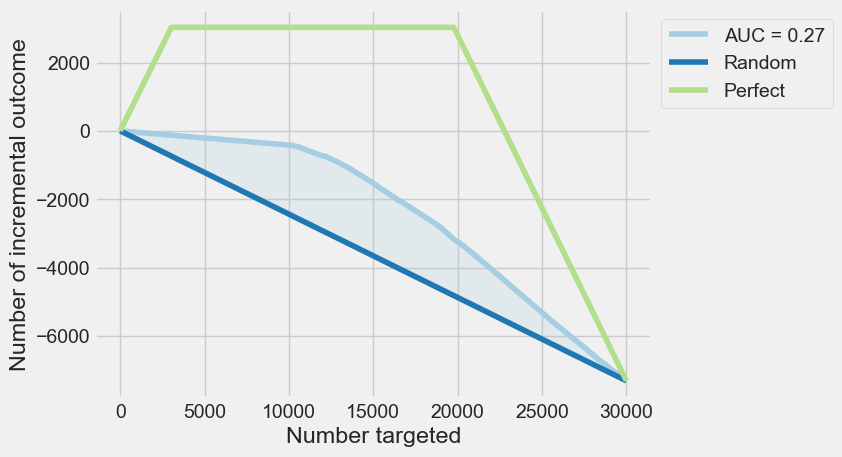

Uplift для кампании: push


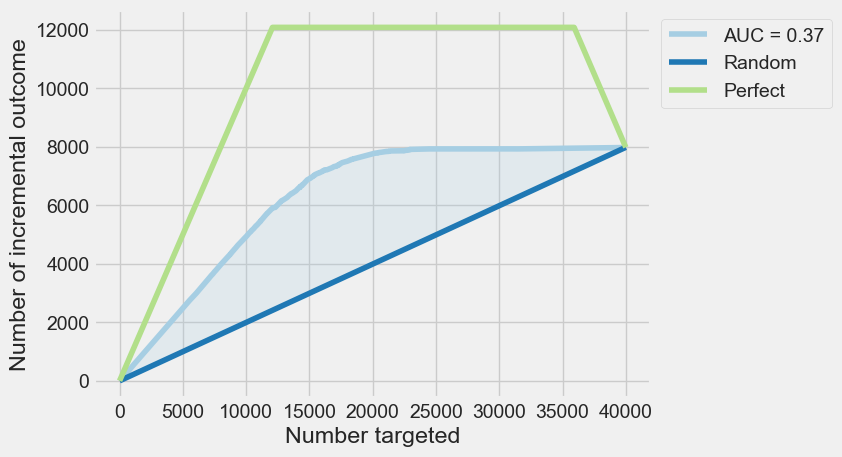

Uplift для кампании: banner


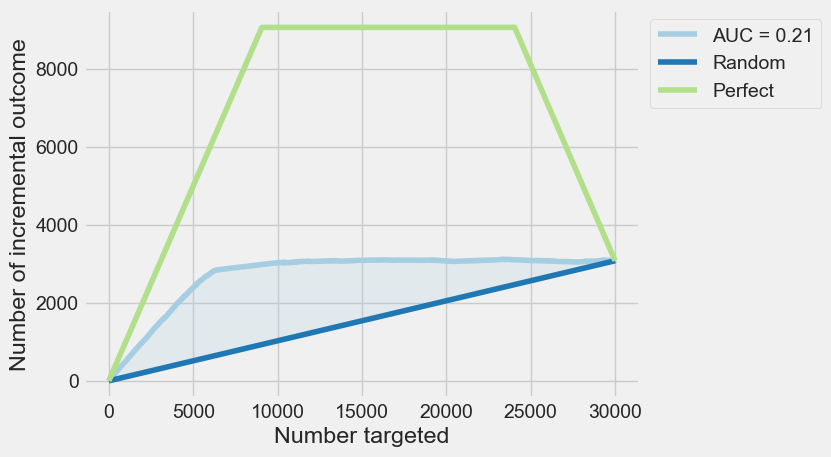

Uplift для кампании: other_ads


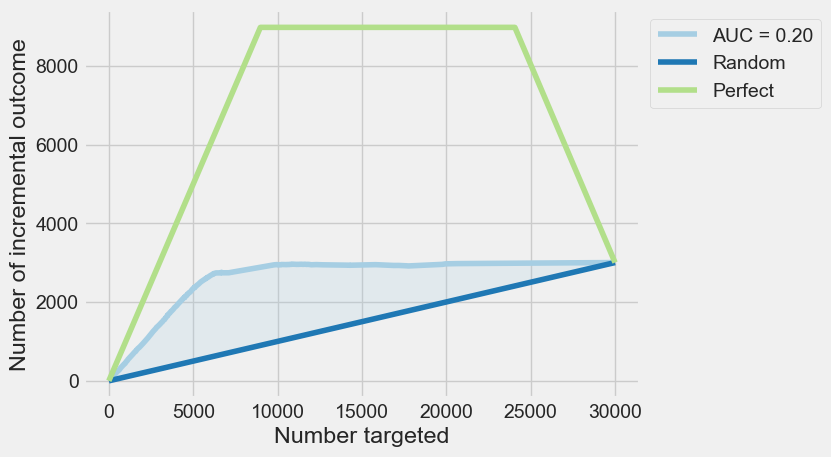

{'sms': 0.26891335990465626,
 'push': 0.3738011683436681,
 'banner': 0.214726293804523,
 'other_ads': 0.20449626134166918}

In [59]:
rf_score = train_uplift_by_campaign(df_joined, uplift_rf, casual_model=True)
rf_score

In [ ]:
import optuna
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 100),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'random_state': RANDOM_STATE,
    }

    model = CatBoostClassifier(silent=True, eval_metric='Logloss', thread_count=-1, **params)

    skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

    calib_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv=skf)

    qini_auc_dict = train_uplift_by_campaign(df_joined, lambda: ClassTransformation(calib_model), show_plots=False)
    qini_auc = sum(qini_auc_dict.values()) / len(qini_auc_dict)

    return qini_auc


def calibrated_class_transformation_with_optuna():
    """
    Class transformation с калибровкой, StratifiedKFold и оптимизацией гиперпараметров через Optuna.
    """
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)

    best_params = study.best_params

    model = CatBoostClassifier(silent=True, eval_metric='Logloss', thread_count=-1, **best_params)
    skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
    calib_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv=skf)

    return ClassTransformation(calib_model)


calibrated_class_transformation_score = train_uplift_by_campaign(df_joined, calibrated_class_transformation_with_optuna,
                                                                 show_plots=False)

In [65]:
calibrated_class_transformation_score

{'sms': 0.34798391639426146,
 'push': 0.3842424485148946,
 'banner': 0.2211384332757711,
 'other_ads': 0.3173489075238357}

In [66]:
models_scores = [
    ('custom_solo_model', custom_solo_model_score),
    ('custom_solo_multicampaign_model', custom_solo_multicampaign_model_score),
    ('two_model', simple_two_model_score),
    ('two_model_calibrated', two_model_calibrated_score),
    ('class_transformation', class_transformation_score),
    ('class_transformation_calibrated', calibrated_class_transformation_score),
    ('random_forest', rf_score),
]

data = []
for model_name, scores in models_scores:
    row = {'model': model_name}
    row.update(scores)
    data.append(row)

pd.DataFrame(data)

,model,sms,push,banner,other_ads
0,custom_solo_model,-0.004214,0.010131,0.003835,-0.000220
1,custom_solo_multicampaign_model,-0.004214,0.010131,0.003835,-0.000220
2,two_model,0.285060,0.384716,0.216605,0.208750
3,two_model_calibrated,0.297884,0.384788,0.210685,0.207638
4,class_transformation,0.344328,0.384338,0.216866,0.314723
5,class_transformation_calibrated,0.347984,0.384242,0.221138,0.317349
6,random_forest,0.268913,0.373801,0.214726,0.204496


Как видно из таблицы, лучше всего справилась Class Tranfsormation на Catboost классификаторе со стратификацией с подбором гиперпараметров с помощью optuna

Прогоним ещё раз (потому что я забыл вернуть модель в функции) и сохраним модели для каждой коммуникации:

In [76]:
campaign_dict = {
    'idclip': 'sms',
    'iddqd': 'push',
    'iddt': 'banner',
    'idkfa': 'other_ads',
}

In [73]:
def get_trained_model(campaing_id: str, model_function):
    df_campaign = df_joined[df_joined['campaing_id'] == campaing_id].copy()
    X_train, X_val, y_train, y_val = split_data(df_campaign.drop(columns=['campaing_id']))

    model = model_function()

    ct = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), ['city']),
        ('scaler', StandardScaler(), num_cols)
    ], remainder='passthrough')

    pipe = Pipeline([
        ('preprocessing', ct),
        ('model_uplift', model)
    ])

    pipe.fit(X_train.drop(columns='t_flag', axis=1), y_train, model_uplift__treatment=X_train['t_flag'])

    return pipe

In [ ]:
models = []

for campaign_id, campaign_name in campaign_dict.items():
    model = get_trained_model(campaign_id, calibrated_class_transformation_with_optuna)
    models.append((campaign_name, model))

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

Возьмем для теста выборку по январю

In [108]:
X_test = df_aggs[(df_aggs['report_dt'].dt.year == 2025) & (df_aggs['report_dt'].dt.month == 1)].drop(
    columns=['report_dt', 'user_id', 'x5'], axis=1)
X_test

,x1,x2,x3,x4,x6,x7,x8,x9,age,city
0,0.654343,-1.439286,-0.011475,2.039457,-0.977480,-0.768019,-1.044127,0.025673,26,Ufa
19,0.238281,-1.221378,0.338246,2.578613,-0.293309,-1.623151,-0.419945,-0.285695,42,Moscow
48,1.262071,-0.590011,-1.487096,-0.966672,0.312791,-0.356535,-0.539563,1.401530,28,Smolensk
66,-6.942073,0.107627,1.760962,4.424731,0.238544,-1.329872,0.288694,-1.625620,32,Moscow
67,-2.200147,0.694959,-1.620087,4.003986,0.214216,-0.330887,-1.386118,1.525752,22,Ufa
...,...,...,...,...,...,...,...,...,...,...
2759961,-0.852355,2.184957,-0.798753,1.716976,-1.836446,-0.407546,-1.819025,0.756988,36,Moscow
2759983,1.343056,0.408401,-2.688668,-0.235793,-0.119657,-1.866503,0.273952,2.557688,31,Smolensk
2759991,-0.999208,0.527982,-2.094625,2.747209,0.237984,-1.318151,-1.509199,1.989945,39,Smolensk
2759996,-1.970020,1.180142,-0.572525,1.052022,0.744590,-2.342623,-0.136155,0.582400,40,Moscow


Для каждого пользователя посчитаем uplift по каждой кампании

In [112]:
final_predictions = []

for campaign, model in models:
    uplift = model.predict(X_test.copy())

    predictions_df = pd.DataFrame({
        'user_id': df_aggs.loc[X_test.index, 'user_id'],
        'campaign': campaign,
        'uplift': uplift
    })

    final_predictions.append(predictions_df)

final_predictions_df = pd.concat(final_predictions, ignore_index=True)
final_predictions_df

,user_id,campaign,uplift
0,1066338,sms,-0.666760
1,25872,sms,-0.690083
2,4107442,sms,-0.713734
3,2047420,sms,-0.746454
4,1120643,sms,-0.470376
...,...,...,...
1839995,4034876,other_ads,0.213444
1839996,114148,other_ads,-0.298212
1839997,143255,other_ads,-0.304394
1839998,132172,other_ads,0.298699


Выберем лучшую кампанию для каждого пользователя. Если uplift < 0.1, то помечаем, что коммуникация не нужна

In [113]:
best_campaigns = final_predictions_df.loc[
    final_predictions_df.groupby('user_id')['uplift'].idxmax()
]
best_campaigns['campaign'] = best_campaigns.apply(
    lambda row: 'no_comm' if row['uplift'] < 0.1 else row['campaign'],
    axis=1
)
best_campaigns

,user_id,campaign,uplift
1531708,1,other_ads,0.250445
817607,2,push,0.903753
817090,3,push,0.487585
464778,4,push,0.655309
654089,5,push,0.991165
...,...,...,...
479921,4119995,push,0.521703
662893,4119996,push,0.917207
760374,4119997,push,0.975215
586692,4119998,push,0.983482


In [115]:
communication_stats = best_campaigns['campaign'].value_counts().reset_index()
communication_stats.columns = ['campaign', 'user_count']

print('Статистика по отправке коммуникаций:')
communication_stats

Статистика по отправке коммуникаций:


,campaign,user_count
0,push,232760
1,other_ads,153561
2,no_comm,50846
3,banner,20245
4,sms,2588


In [117]:
uplift_stats = best_campaigns['uplift'].apply(
    lambda x: 'Uplift >= 0.1' if x >= 0.1 else 'Uplift < 0.1').value_counts().reset_index()
uplift_stats.columns = ['uplift_category', 'user_count']

print('Статистика по Uplift:')
uplift_stats

Статистика по Uplift:


,uplift_category,user_count
0,Uplift >= 0.1,409154
1,Uplift < 0.1,50846


В данной работе был проведен анализ данных по 4 коммуникациям пользователей. Для кампании `other_ads` один из признаков был не корректен (`x5`), было решено от него избавиться от греха подальше для всех кампаний. Так же были обнаружены пересечения пользователей в контрольной и целевой группах 2 кампаний: `sms` и `push`, поэтому было решено строить отдельные модели для каждой кампании.


('custom_solo_model', custom_solo_model_score),
    ('custom_solo_multicampaign_model', custom_solo_multicampaign_model_score),
    ('two_model', simple_two_model_score),
    ('two_model_calibrated', two_model_calibrated_score),
    ('class_transformation', class_transformation_score),
    ('class_transformation_calibrated', calibrated_class_transformation_score),
    ('random_forest', rf_score),

Были реализованы следующие модели:
- Кастомная Solo model
- Two model из библиотеки sklift
- Two model с калибровкой
- Class Transformation на Catboost классификаторе
- Class Transformation на Catboost классификаторе с калибровкой, стратификацией и подбором параметров с помощью optune
- Случайный лес для uplift из библиотеки CausualML

Для предобратоки признаков были использованы OneHotEcnoder и StandardScaler.

Лучший результат показала Catboost с optune, поэтому она была выбрана для предсказаний на тестовой выборке. По итогу для каждого пользователя была выбрана наиболее подходящая кампания для коммуникации или её отсутствие.

Из 460 000 пользователей для `push`-коммуникации модель выбрала почти половину пользователей, для 50 846 пользователей никакая коммуникация не требуется для увеличения количества продаж.